,TIME,GOVERNMENT,INSURGENT,NEUTRAL
0,0,"8,000",950,"-6,950"
1,1,"7,994",918,0
2,2,"7,988",891,0
3,3,"7,984",887,2
4,4,"7,975",878,4
5,5,"7,957",871,10
6,6,"7,932",867,21
7,7,"7,901",865,33
8,8,"7,866",864,49
9,9,"7,826",865,67


,TIME,INS TROOPS (TI),GOV TROOPS (TG),GOV REQ (TMG),EXCH RATIO (DG/DI)
0,0,636,"1,000","1,000",2.00
1,1,576,936,"1,000",2.14
2,2,107,909,"1,000",2.20
3,3,128,"1,633","1,000",1.23
4,4,120,"1,754","1,000",1.14
5,5,118,"1,522","1,000",1.31
6,6,119,"1,365","1,000",1.46
7,7,119,"1,397","1,000",1.43
8,8,119,"1,406","1,000",1.42
9,9,120,"1,405","1,000",1.42


,TIME,REG DES,REG ADD,REG REM,POL DES,POL ADD
0,0,0,0,0,0,0
1,1,64,21,0,18,9
2,2,91,45,0,"1,371",690
3,3,0,0,211,0,345
4,4,0,0,392,0,172
5,5,0,0,435,0,86
6,6,0,0,412,0,43
7,7,0,0,407,0,22
8,8,0,0,407,0,11
9,9,0,0,406,0,5


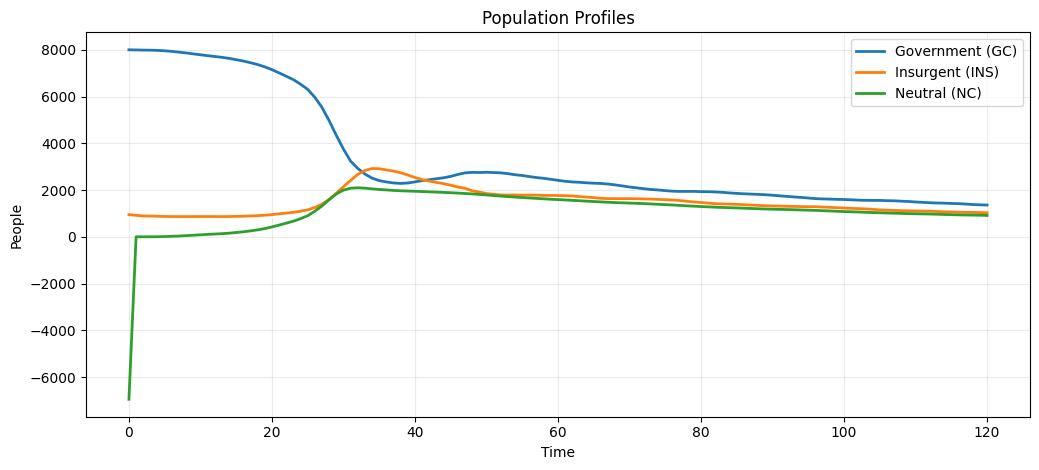

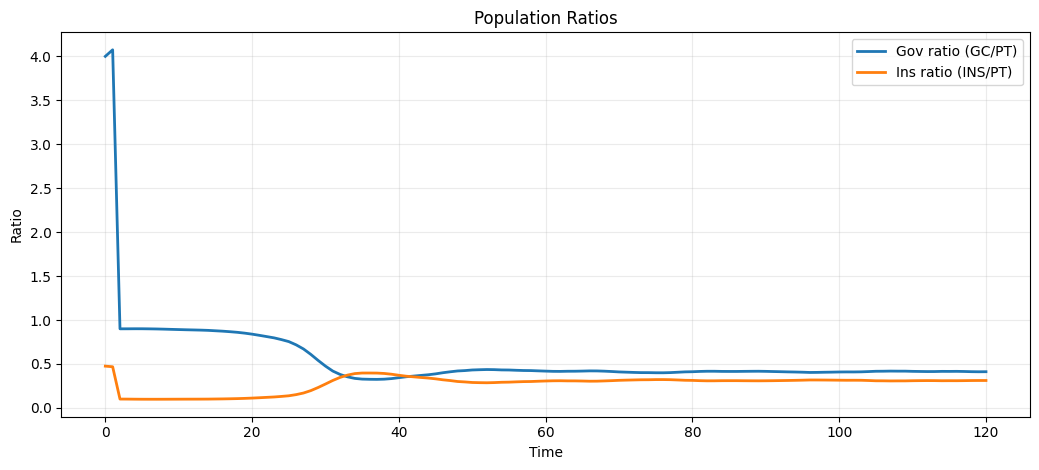

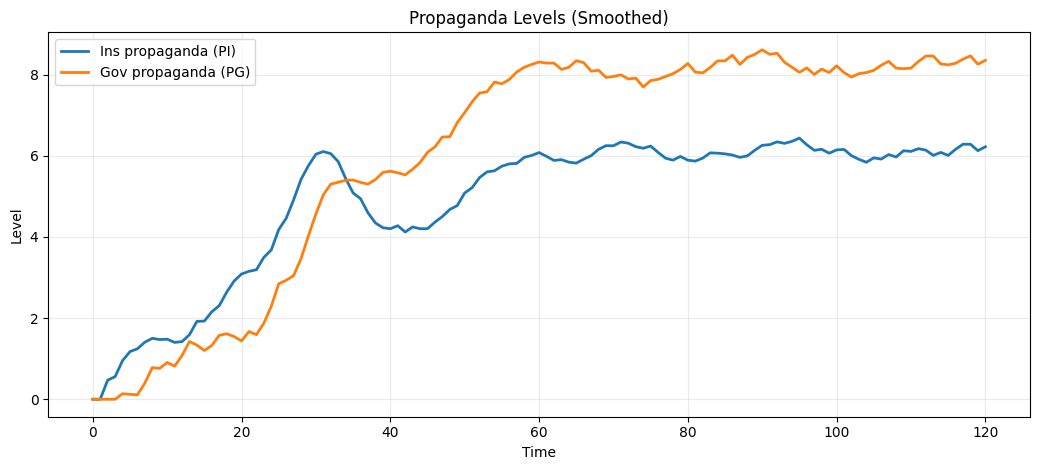

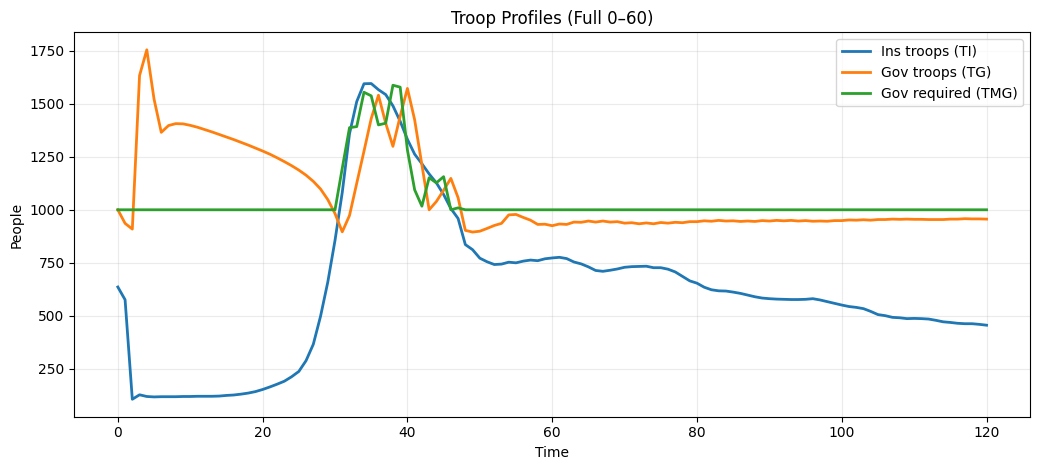

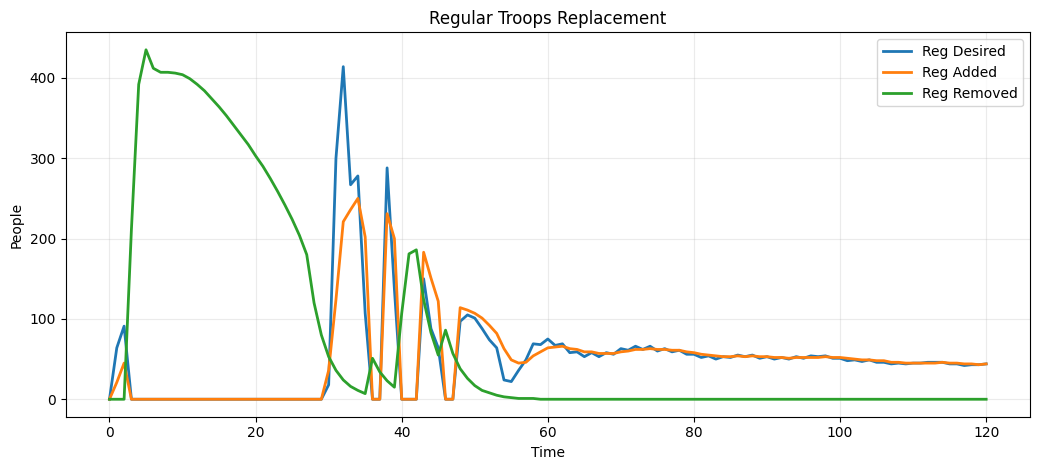

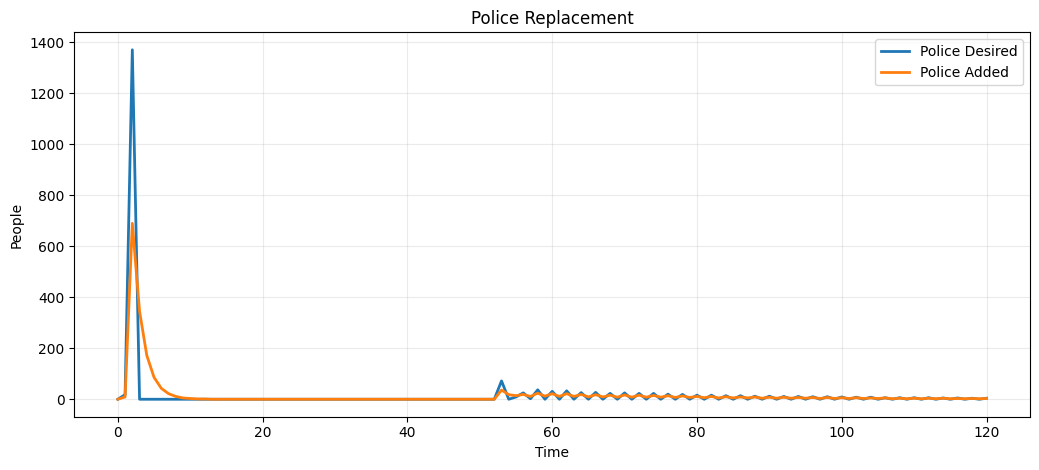

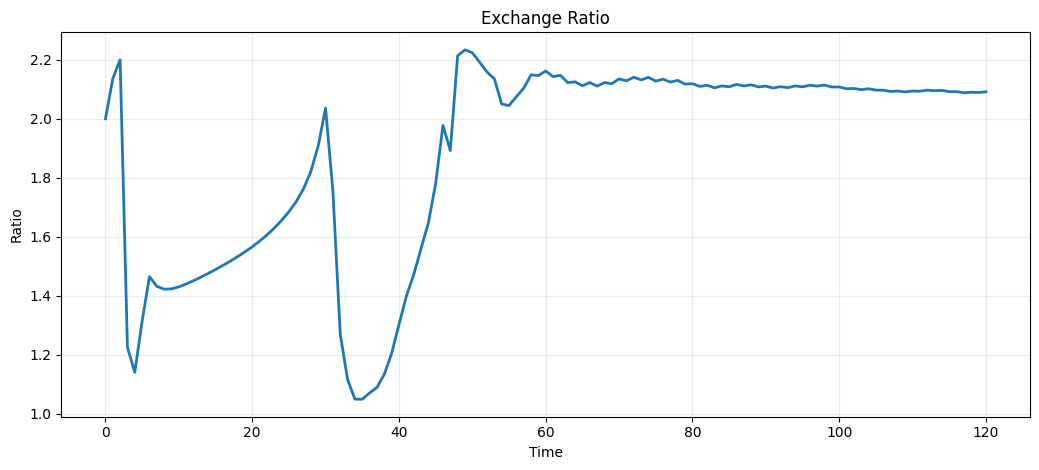

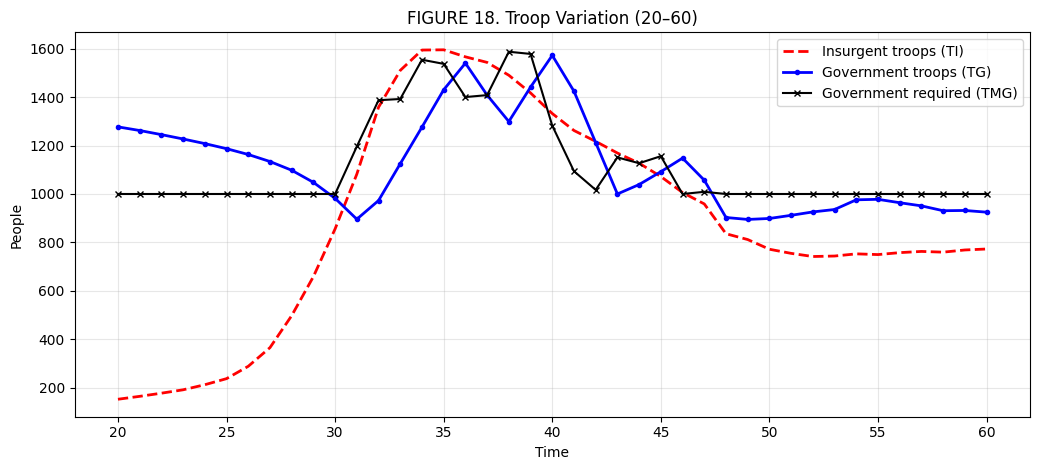

,Metric,Value
0,Initial GC,8000
1,Initial INS,950
2,Initial NC,-6950
3,Final GC,1358
4,Final INS,1028
5,Final NC,913
6,Peak TI,1595
7,TI peak time,35
8,Peak TG,1754
9,TG peak time,4


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# =========================
# Helpers
# =========================
def table_lookup(table, x, xmin, xmax, step):
    if x <= xmin: return table[0]
    if x >= xmax: return table[-1]
    idx = (x - xmin) / step
    i = int(np.floor(idx))
    frac = idx - i
    return table[i] + frac * (table[i + 1] - table[i])

class Delay1:
    def __init__(self, delay_time, initial_value=0.0):
        self.delay_time = float(delay_time)
        self.state = float(initial_value)
    def update(self, input_val, dt=1.0):
        self.state += (dt / self.delay_time) * (float(input_val) - self.state)
        return self.state

def _clamp01(x):
    return max(0.0, min(1.0, float(x)))

def _nice_header(title):
    display(HTML(f"""
    <div style="margin: 16px 0 10px 0; padding: 10px 14px; border-radius: 10px; 
                background: #f6f7f9; border: 1px solid #e5e7eb; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Arial;">
      <div style="font-size: 18px; font-weight: 700; color: #111827;">{title}</div>
    </div>
    """))

def _style_table_int(df, title=None, max_rows=200):
    if title:
        _nice_header(title)
    df_show = df.copy()
    if len(df_show) > max_rows:
        df_show = df_show.iloc[:max_rows].copy()

    sty = (
        df_show.style
        .format("{:,.0f}")
        .set_properties(**{
            "font-family": "-apple-system, BlinkMacSystemFont, 'Segoe UI', Arial",
            "font-size": "12.5px",
            "border-color": "#e5e7eb",
        })
        .set_table_styles([
            {"selector": "th", "props": [("background-color", "#f3f4f6"), ("color", "#111827"),
                                         ("font-weight", "700"), ("border", "1px solid #e5e7eb"),
                                         ("padding", "8px")]},
            {"selector": "td", "props": [("border", "1px solid #e5e7eb"), ("padding", "6px 8px")]},
        ])
    )
    display(sty)

def _style_table_mixed(df, title=None, int_cols=None, float_cols=None, max_rows=200):
    if title:
        _nice_header(title)
    df_show = df.copy()
    if len(df_show) > max_rows:
        df_show = df_show.iloc[:max_rows].copy()

    fmt = {}
    int_cols = int_cols or []
    float_cols = float_cols or []
    for c in int_cols:
        if c in df_show.columns:
            fmt[c] = "{:,.0f}"
    for c in float_cols:
        if c in df_show.columns:
            fmt[c] = "{:,.2f}"

    sty = (
        df_show.style
        .format(fmt)
        .set_properties(**{
            "font-family": "-apple-system, BlinkMacSystemFont, 'Segoe UI', Arial",
            "font-size": "12.5px",
            "border-color": "#e5e7eb",
        })
        .set_table_styles([
            {"selector": "th", "props": [("background-color", "#f3f4f6"), ("color", "#111827"),
                                         ("font-weight", "700"), ("border", "1px solid #e5e7eb"),
                                         ("padding", "8px")]},
            {"selector": "td", "props": [("border", "1px solid #e5e7eb"), ("padding", "6px 8px")]},
        ])
    )
    display(sty)

def _plot_line(x, series, title, xlabel="Time", ylabel="", legend_loc="best"):
    plt.figure(figsize=(10.5, 4.8))
    for name, y in series.items():
        plt.plot(x, y, lw=2, label=name)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.25)
    if len(series) > 1:
        plt.legend(loc=legend_loc)
    plt.tight_layout()
    plt.show()

# =========================
# Tables from appendix (as you provided)
# =========================
TABLE_DATA = {
    'TPIT':  [0, .1, .5, 1.5, 6, 8.8, 10, 9, 5.5, 2.5, 0],
    'TPRI':  [0, .02, .05, .08, .17, .45, .67, .75, .79, .80, .80],
    'TPFHI': [0, .12, .22, .3, .38, .41, .46, .48, .49, .49, .5],
    'TPFGI': [0, .05, .1, .15, .18, .19],
    'TPFGN': [0, .1, .2, .23, .34, .35],
    'TPGT':  [0, 1, 3, 5, 8, 10, 8, 5, 3, 1, 0],
    'TPRG':  [0, .02, .05, .09, .13, .26, .6, .85, .92, .97, 1],
    'TPFIN': [0, .03, .06, .15, .23, .26],
    'TPFIG': [0, .03, .12, .16, .18, .19],
    'TPFNG': [0, .05, .1, .25, .37, .39],
    'TPINS': [0, .15, .33, .45, .58, .7, .67, .58, .45, .4, .4],
    'TTMG':  [1000, 1000, 2000, 3000, 4000, 5000],
    'TFCI':  [.1, .1, .125, .15, .175, .2],
    'TFCG':  [.00005, .00005, .00015, .0002, .0002, .0002],
    'TEENC': [1, 1, 15, 25, 30, 30],
    'TFST':  [0, 50, 100, 200, 300, 500]
}

# =========================
# Your simulation (logic unchanged)
# =========================
def run_simulation(length=120, dt=1.0, gcc=2000, seed=42):
    rng = np.random.default_rng(seed)
    T = TABLE_DATA
    PT, INS, GC = 2000.0, 950.0, float(gcc)
    NC = PT - INS - GC
    
    PIPRE = table_lookup(T['TPIT'], GC/PT, 0, 1, 0.1)
    PGPRE = table_lookup(T['TPGT'], GC/PT, 0, 1, 0.1)
    PI, PG = PIPRE, PGPRE
    TGPTEP = 0.0
    
    TI = table_lookup(T['TPINS'], INS/PT, 0, 1, 0.1) * INS
    TGP = 0.05 * PT
    TMG_init = table_lookup(T['TTMG'], TI, 0, 5000, 1000)
    TGR = max(0.0, TMG_init - TGP)
    
    del_tgp, del_tgr_add, del_tgr_rem = Delay1(2.0), Delay1(3.0), Delay1(3.0)
    history = []

    for step in range(length + 1):
        t = step * dt
        NCR, GCR, IR = NC/PT, GC/PT, INS/PT
        
        # Propaganda
        IMI, IMG = rng.uniform(-0.5, 0.5) / 5.0, rng.uniform(-0.5, 0.5) / 2.5
        PIT = table_lookup(T['TPIT'], _clamp01(IMI*GCR + GCR), 0, 1, 0.1)
        PI = 0.1 * PIT + 0.9 * PIPRE
        PGT = table_lookup(T['TPGT'], _clamp01(IMG*GCR + GCR), 0, 1, 0.1)
        PG = 0.1 * PGT + 0.9 * PGPRE
        
        PRI = table_lookup(T['TPRI'], PI, 0, 10, 1)
        PRG = table_lookup(T['TPRG'], PG, 0, 10, 1)

        PNHI = PRI * NCR * table_lookup(T['TPFHI'], PI, 0, 10, 1)
        PMGI = PRI * GCR * table_lookup(T['TPFGI'], PI, 0, 10, 2)
        PMGN = PRI * GCR * table_lookup(T['TPFGN'], PI, 0, 10, 2)
        PMIN = PRG * IR * table_lookup(T['TPFIN'], PG, 0, 10, 2)
        PMIG = PRG * IR * table_lookup(T['TPFIG'], PG, 0, 10, 2)
        PMNG = PRG * NCR * table_lookup(T['TPFNG'], PG, 0, 10, 2)
        
        # Combat
        TG = TGR + TGP
        TMG = table_lookup(T['TTMG'], TI + IMG*TI, 0, 5000, 1000)
        FST = table_lookup(T['TFST'], TI, 0, 5000, 1000)

        AFSG = FST if TI >= 1000 else TG
        AFSI = FST if TI >= 1000 else TI
        EENC = table_lookup(T['TEENC'], TI, 0, 5000, 1000)
        IC = 1000.0 if TI >= 1000 else (EENC * AFSI)

        DG = table_lookup(T['TFCI'], TI, 0, 5000, 1000) * (EENC * AFSI)
        DI = table_lookup(T['TFCG'], TI, 0, 5000, 1000) * (EENC * AFSG) * IC
        
        # Replacement (Ratchet Logic)
        TGPTE1 = max(0.0, (0.05 * PT) - TGP)
        TGPACT = max(TGPTE1, TGPTEP)
        TGPDES = 4.0 * (TGPACT - TGPTEP)
        TGPADD = del_tgp.update(TGPDES, dt)

        TGRDIF = TMG - TGP - TGR
        TGRADD = del_tgr_add.update(max(0.0, TGRDIF), dt) if TGRDIF >= 0 else 0.0
        TGRSURT = del_tgr_rem.update(max(0.0, -TGRDIF) if -TGRDIF >= 100 else 0.0, dt)

        killr = (DG / DI) if DI > 1e-12 else np.nan

        history.append({
            'Time': t,
            'GC': GC, 'INS': INS, 'NC': NC, 'PT': PT,
            'IR': IR, 'GCR': GCR,
            'PI': PI, 'PG': PG,
            'TI': TI, 'TG': TG, 'TMG': TMG,
            'DG': DG, 'DI': DI, 'KILLR': killr,
            'RegDes': max(0.0, TGRDIF), 'RegAdd': TGRADD, 'RegRem': TGRSURT,
            'PolDes': TGPDES, 'PolAdd': TGPADD
        })
        
        if step >= length: 
            break

        # Update levels
        REGF = TGR/(TGR+TGP) if (TGR+TGP)>0 else 0.5
        POLF = 1.0 - REGF
        NCSAF = 1.0 if NC >= 0 else 0.0

        IGR = PNHI*NC*NCSAF + PMGI*GC
        IAR = (PMIN+PMIG)*INS + DI
        GGR = PMNG*NC*NCSAF + PMIG*INS
        GAR = (PMGN+PMGI)*GC + POLF*DG

        INS += dt*(IGR-IAR)
        GC  += dt*(GGR-GAR)

        NC += dt*((PMIN*INS + PMGN*GC) - (PNHI*NC + PMNG*NC))

        PT = GC + INS + NC

        TI += dt*(table_lookup(T['TPINS'], INS/PT, 0, 1, 0.1)*INS - TI - DI)
        TGP += dt*(TGPADD - POLF*DG)
        TGR += dt*(TGRADD - TGRSURT - REGF*DG)

        PIPRE, PGPRE, TGPTEP = PI, PG, TGPTE1

        # Non-negative hygiene
        INS = max(0.0, INS)
        GC  = max(0.0, GC)
        NC  = max(0.0, NC)
        PT  = max(0.0, PT)
        TI  = max(0.0, TI)
        TGP = max(0.0, TGP)
        TGR = max(0.0, TGR)

    return pd.DataFrame(history)

# =========================
# Run
# =========================
gcc = 8000
seed = 42
df = run_simulation(gcc=gcc, seed=seed)

csv_path = "insurgency_standard_run.csv"
df.to_csv(csv_path, index=False)

display(HTML(f"""
<div style="padding: 12px 14px; border-radius: 12px; background: #0b1220; color: #e5e7eb;
            font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Arial; margin-bottom: 12px;">
  <div style="font-size: 18px; font-weight: 800;">INSURGENCY GROWTH MODEL</div>
  <div style="font-size: 13px; opacity: 0.9; margin-top: 4px;">
    Run: gcc=<b>{gcc}</b>, seed=<b>{seed}</b>, length=<b>{int(df['Time'].max())}</b>, dt=<b>1</b>.
    CSV saved: <b>{csv_path}</b>
  </div>
</div>
"""))

# =========================
# TABLE II / IV / V (rounded to integers for people)
# =========================

# TABLE II
tbl2 = df[["Time", "GC", "INS", "NC"]].copy()
tbl2.columns = ["TIME", "GOVERNMENT", "INSURGENT", "NEUTRAL"]
tbl2[["GOVERNMENT", "INSURGENT", "NEUTRAL"]] = tbl2[["GOVERNMENT", "INSURGENT", "NEUTRAL"]].round(0)
_style_table_int(tbl2, "TABLE II. Population Profiles (people)", max_rows=200)

# TABLE IV
tbl4 = df[["Time", "TI", "TG", "TMG", "KILLR"]].copy()
tbl4.columns = ["TIME", "INS TROOPS (TI)", "GOV TROOPS (TG)", "GOV REQ (TMG)", "EXCH RATIO (DG/DI)"]
tbl4[["INS TROOPS (TI)", "GOV TROOPS (TG)", "GOV REQ (TMG)"]] = tbl4[["INS TROOPS (TI)", "GOV TROOPS (TG)", "GOV REQ (TMG)"]].round(0)
_style_table_mixed(
    tbl4,
    "TABLE IV. Troop Profiles",
    int_cols=["TIME", "INS TROOPS (TI)", "GOV TROOPS (TG)", "GOV REQ (TMG)"],
    float_cols=["EXCH RATIO (DG/DI)"],
    max_rows=200
)

# TABLE V
tbl5 = df[["Time", "RegDes", "RegAdd", "RegRem", "PolDes", "PolAdd"]].copy()
tbl5.columns = ["TIME", "REG DES", "REG ADD", "REG REM", "POL DES", "POL ADD"]
tbl5[["REG DES", "REG ADD", "REG REM", "POL DES", "POL ADD"]] = tbl5[["REG DES", "REG ADD", "REG REM", "POL DES", "POL ADD"]].round(0)
_style_table_int(tbl5, "TABLE V. Troop Replacement Figures (people)", max_rows=200)

# =========================
# FIGURES (people plotted as integers)
# =========================
_nice_header("FIGURES (people plotted as integers)")

_plot_line(
    df["Time"].values,
    {
        "Government (GC)": np.rint(df["GC"].values),
        "Insurgent (INS)": np.rint(df["INS"].values),
        "Neutral (NC)": np.rint(df["NC"].values),
    },
    "Population Profiles",
    ylabel="People"
)

_plot_line(
    df["Time"].values,
    {
        "Gov ratio (GC/PT)": df["GCR"].values,
        "Ins ratio (INS/PT)": df["IR"].values,
    },
    "Population Ratios",
    ylabel="Ratio"
)

_plot_line(
    df["Time"].values,
    {
        "Ins propaganda (PI)": df["PI"].values,
        "Gov propaganda (PG)": df["PG"].values
    },
    "Propaganda Levels (Smoothed)",
    ylabel="Level"
)

_plot_line(
    df["Time"].values,
    {
        "Ins troops (TI)": np.rint(df["TI"].values),
        "Gov troops (TG)": np.rint(df["TG"].values),
        "Gov required (TMG)": np.rint(df["TMG"].values),
    },
    "Troop Profiles (Full 0–60)",
    ylabel="People"
)

_plot_line(
    df["Time"].values,
    {
        "Reg Desired": np.rint(df["RegDes"].values),
        "Reg Added": np.rint(df["RegAdd"].values),
        "Reg Removed": np.rint(df["RegRem"].values),
    },
    "Regular Troops Replacement",
    ylabel="People"
)

_plot_line(
    df["Time"].values,
    {
        "Police Desired": np.rint(df["PolDes"].values),
        "Police Added": np.rint(df["PolAdd"].values),
    },
    "Police Replacement",
    ylabel="People"
)

_plot_line(
    df["Time"].values,
    {
        "Exchange ratio (DG/DI)": df["KILLR"].values
    },
    "Exchange Ratio",
    ylabel="Ratio"
)

# =========================
# FIGURE 18 (window 20–60)
# =========================
_nice_header("FIGURE 18. Troop Variation (t = 20–60)")

mask = (df["Time"] >= 20) & (df["Time"] <= 60)

plt.figure(figsize=(10.5, 4.8))

plt.plot(
    df.loc[mask, "Time"].values,
    np.rint(df.loc[mask, "TI"].values),
    'r--',
    lw=2,
    label="Insurgent troops (TI)"
)

plt.plot(
    df.loc[mask, "Time"].values,
    np.rint(df.loc[mask, "TG"].values),
    'b-',
    lw=2,
    marker='o',
    markersize=3,
    label="Government troops (TG)"
)

plt.plot(
    df.loc[mask, "Time"].values,
    np.rint(df.loc[mask, "TMG"].values),
    'k-',
    lw=1.5,
    marker='x',
    markersize=4,
    label="Government required (TMG)"
)

plt.xlabel("Time")
plt.ylabel("People")
plt.title("FIGURE 18. Troop Variation (20–60)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# RUN SUMMARY
# =========================
_nice_header("RUN SUMMARY")
summary = pd.DataFrame({
    "Metric": [
        "Initial GC", "Initial INS", "Initial NC",
        "Final GC", "Final INS", "Final NC",
        "Peak TI", "TI peak time",
        "Peak TG", "TG peak time",
    ],
    "Value": [
        int(round(df.loc[0, "GC"])), int(round(df.loc[0, "INS"])), int(round(df.loc[0, "NC"])),
        int(round(df.loc[df.index[-1], "GC"])), int(round(df.loc[df.index[-1], "INS"])), int(round(df.loc[df.index[-1], "NC"])),
        int(round(df["TI"].max())), int(df.loc[df["TI"].idxmax(), "Time"]),
        int(round(df["TG"].max())), int(df.loc[df["TG"].idxmax(), "Time"]),
    ]
})
display(summary.style.set_properties(**{"font-family": "-apple-system, BlinkMacSystemFont, 'Segoe UI', Arial"}))